# Предсказание дебита жидкости нефтяных скважин методами линейной регрессии и регрессионных деревьев

В данной работе будет произведено предсказание на месяц дебита жидкости для каждой из скважин датасета.

# Описание данных
Датасет содержит данные о характеристиках нефтяных скважин. Набор данных включает следующие поля:
- `Скважина` — номер нефтяной скважины,
- `Дата` — дата снятия показаний,
- `Забойное давление` — рабочее давление скважины,
- `Дебит жидкости` — характеристика жидкости,
- `Дебит нефти` — характеристика нефти,
- `Обводненность`.

In [2]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
bores_df = pd.read_excel('bores_df.xlsx')

In [46]:
bores_df.head()

,Скважина,Дата,Забойное давление,Дебит жидкости,Дебит нефти,Обводненность
0,1,1999-01-01 00:00:00,37.994385,8.0,7.2,0.1
1,1,1999-01-02 00:00:00,37.994385,8.0,7.2,0.1
2,1,1999-01-03 00:00:00,37.994385,8.0,7.2,0.1
3,1,1999-01-04 00:00:00,37.784920,7.0,6.3,0.1
4,1,1999-01-05 00:00:00,37.784920,7.0,6.3,0.1


In [47]:
bores_df.dtypes

Скважина               int64
Дата                  object
Забойное давление    float64
Дебит жидкости       float64
Дебит нефти          float64
Обводненность        float64
dtype: object

Приведение даты к типу datetime

In [48]:
bores_df['Дата'] = pd.to_datetime(bores_df['Дата'], format='%Y-%m-%d', errors='coerce')

Функция извлечения исследуемой скважины:

In [49]:
def num_bore(df, num):
    return df.loc[df['Скважина'] == num]

In [50]:
print(f'Введите номер скважины из доступных: {bores_df["Скважина"].unique()}')
bore = num_bore(bores_df, int(input()))
date = bore['Дата'][-30:].reset_index().drop('index', axis=1) #месяц, для которого будет производиться предсказание
bore = bore.set_index(bore['Дата'])
bore = bore.drop(['Скважина','Дата'], axis=1)

Введите номер скважины из доступных: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
1


<AxesSubplot:>

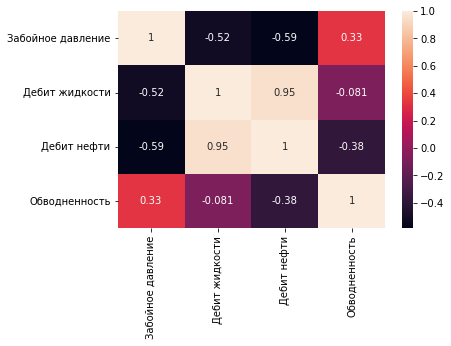

In [51]:
sns.heatmap(bore.corr(), annot=True)
#Дебит нефти = дебит жидкости - дебит жидкости*обводнённость

Из тепловой карты выше, можно увижеть сильную положительную корреляцию дебита жидкости и дебита нефти,
а также значимые отрицательльные корреляции дебита жидкости с забойным давлением и забойного давления с дебитом нефти

Посмотрим распределение дебита жидкости по времени

<AxesSubplot:xlabel='Дата'>

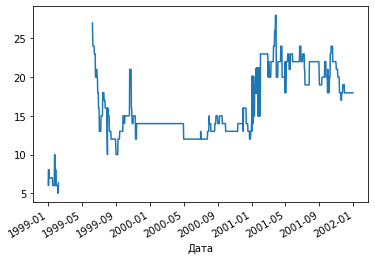

In [52]:
bore['Дебит жидкости'].plot()

Из представленного выше распределения видны пропущенные значения, посчитаем их количество

In [56]:
bore.isnull().sum()

Забойное давление    0
Дебит жидкости       0
Дебит нефти          0
Обводненность        0
dtype: int64

Эти значения обуславливаются выводом скважины из строя, поэтому заменим их нулями

In [55]:
bore = bore.fillna(0)

Подготовим обучающие и тестовые выборки для дальнейшего обучения модели:

In [57]:
X = bore[['Забойное давление','Дебит нефти']]
y = bore['Дебит жидкости']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X[:-30], #последние 30 значений оставляем на задачу предсказания
                                                    y[:-30], #последние 30 значения оставляем на проверку предсказания
                                                    test_size=0.25,
                                                    random_state=42)

Создадим две модели обучения: методом линейной регрессии и методом регрессионного дерева

In [59]:
lr = LinearRegression()
dtr = tree.DecisionTreeRegressor()

Обучим модель линейной регресии и посмотрим на коэффициент детерминации

In [60]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9705571821516905

Обучим модель регрессионного дерева и посмотрим на коэффициент детерминации

In [62]:
parameters = {'criterion': ['friedman_mse', 'poisson'], #параметры были выбраны исходя из возможного переобучения дерева
             'max_depth': range(1,20),
             'min_samples_split': range(10,100,10),
             'min_samples_leaf': range(10,100,10)}

In [63]:
grid_search_cv_reg = GridSearchCV(dtr, parameters, cv=5)

In [64]:
grid_search_cv_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['friedman_mse', 'poisson'],
                         'max_depth': range(1, 20),
                         'min_samples_leaf': range(10, 100, 10),
                         'min_samples_split': range(10, 100, 10)})

In [65]:
grid_search_cv_reg.best_params_ #посмотрим на лучшие параметры дерева

{'criterion': 'friedman_mse',
 'max_depth': 8,
 'min_samples_leaf': 10,
 'min_samples_split': 40}

In [66]:
tree_reg = grid_search_cv_reg.best_estimator_ #передадим лучшие параметры нашей новой модели

In [67]:
tree_reg.score(X_test, y_test)

0.9684633332165837

Сделаем предсказание на 30 дней и построим графики для ознакомления с результатом обучения

In [68]:
y_pred_lr = pd.DataFrame({'Дебит жидкости':lr.predict(X[-30:])}) #предсказание линейн
y_pred_dtr = pd.DataFrame({'Дебит жидкости':tree_reg.predict(X[-30:])})